In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)

import itertools

import statsmodels.api as sm
import plotly.io as pio
pio.templates.default = 'plotly_dark'

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8,6)

In [2]:
data = pd.read_csv('./Oil Prices.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-09-01,190.825043,205.500046,190.825043,200.050049,151.223679,24913429
1,2016-10-01,201.550049,210.750046,201.175049,208.000046,160.468979,14164128
2,2016-11-01,208.500046,223.000061,189.525040,209.675049,161.761230,23076059
3,2016-12-01,213.250046,226.750061,211.575058,226.050049,174.394318,19562304
4,2017-01-01,226.350052,247.500061,217.333328,219.766663,169.546753,33479880


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       61 non-null     datetime64[ns]
 1   Open       61 non-null     float64       
 2   High       61 non-null     float64       
 3   Low        61 non-null     float64       
 4   Close      61 non-null     float64       
 5   Adj Close  61 non-null     float64       
 6   Volume     61 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 3.5 KB


In [4]:
data1 = data.copy()
data = data.set_index('Date')
data1.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
close_price = data['Close'].resample('MS').mean()
close_price

Date
2016-09-01    200.050049
2016-10-01    208.000046
2016-11-01    209.675049
2016-12-01    226.050049
2017-01-01    219.766663
2017-02-01    218.066666
2017-03-01    222.533340
2017-04-01    218.100006
2017-05-01    204.533340
2017-06-01    173.066666
2017-07-01    191.666672
2017-08-01    190.100006
2017-09-01    235.766663
2017-10-01    246.033340
2017-11-01    241.300003
2017-12-01    247.666672
2018-01-01    239.300003
2018-02-01    233.233337
2018-03-01    216.350006
2018-04-01    232.449997
2018-05-01    215.850006
2018-06-01    209.850006
2018-07-01    209.050003
2018-08-01    213.600006
2018-09-01    219.550003
2018-10-01    197.600006
2018-11-01    186.250000
2018-12-01    174.800003
2019-01-01    167.649994
2019-02-01    174.600006
2019-03-01    185.449997
2019-04-01    180.850006
2019-05-01    180.000000
2019-06-01    178.000000
2019-07-01    159.500000
2019-08-01    147.949997
2019-09-01    145.250000
2019-10-01    171.649994
2019-11-01    154.050003
2019-12-01    153.05

In [6]:
fig = px.line(data1,x='Date', y=['Close','Open','High','Low'], title="Oil Prices the years")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [7]:
fig = px.line(data1,x='Date', y=['Close'], title="Closing Prices through the years")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [8]:
fig = px.line(data1,x='Date', y=['Volume'], title="Volume")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Working on Closing Prices

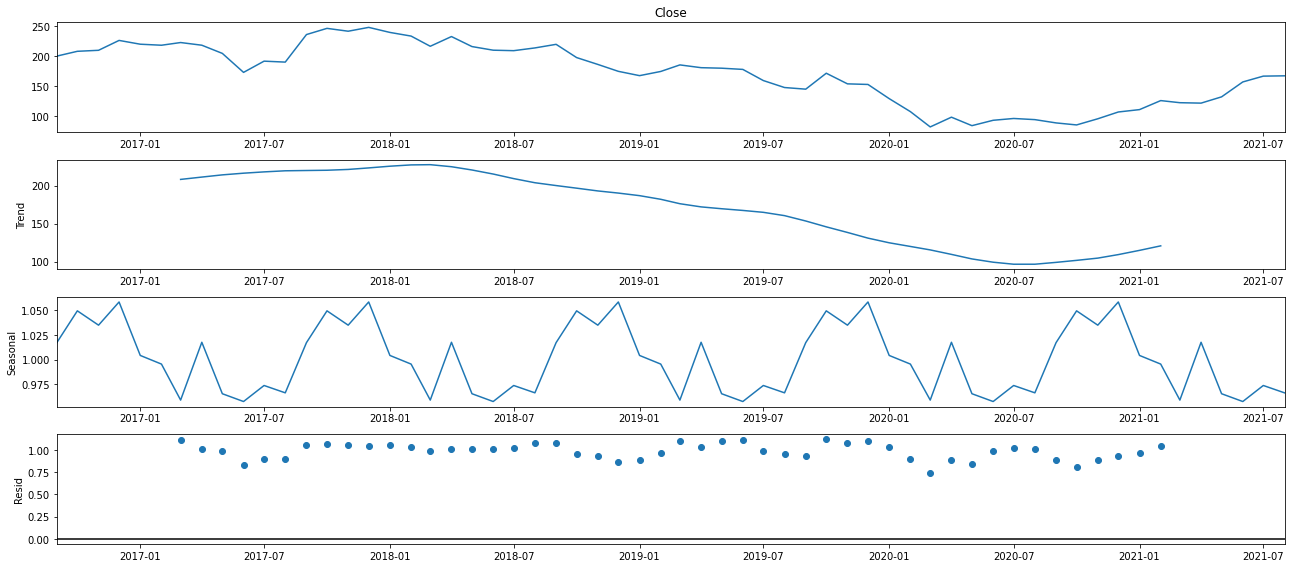

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8

decomposition = sm.tsa.seasonal_decompose(close_price, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [10]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [11]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(close_price,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:780.6932281557021
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:587.8483216861886
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:506.91840737320604
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1089.1515145913336
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:506.45574588627863
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:479.00348773408507
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:398.5124506870651
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1432.8967521365398
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:698.5428948677863
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:522.3867401289579
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:458.83092160986007
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1288.608507686553
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:469.63289875559235
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:451.92542195941724
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:366.6447602341944
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1255.4710986912883
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:471.70027459733797
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:363.87087604538516

In [12]:
mod = sm.tsa.statespace.SARIMAX(close_price,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5343      0.685      0.779      0.436      -0.809       1.878
ma.L1         -0.2947      0.798     -0.369      0.712      -1.858       1.269
ar.S.L12      -0.6651      0.141     -4.706      0.000      -0.942      -0.388
sigma2       243.8273     86.019      2.835      0.005      75.233     412.421


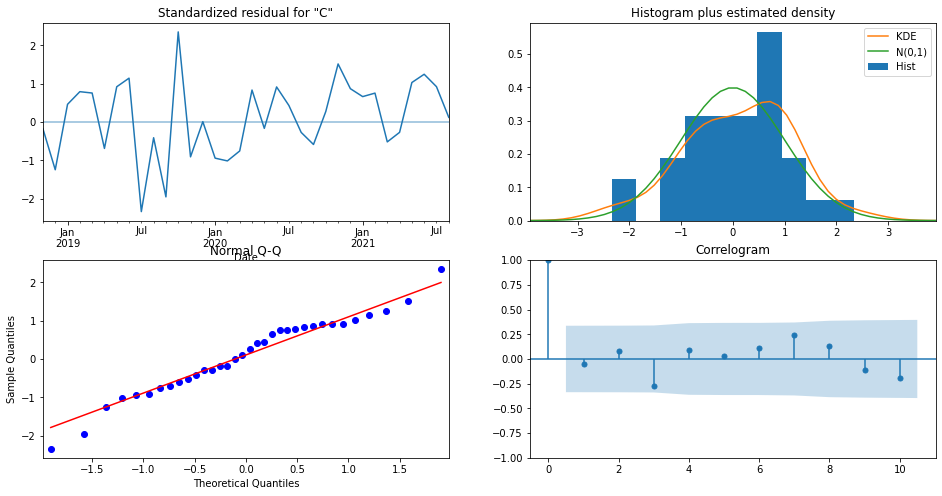

In [13]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

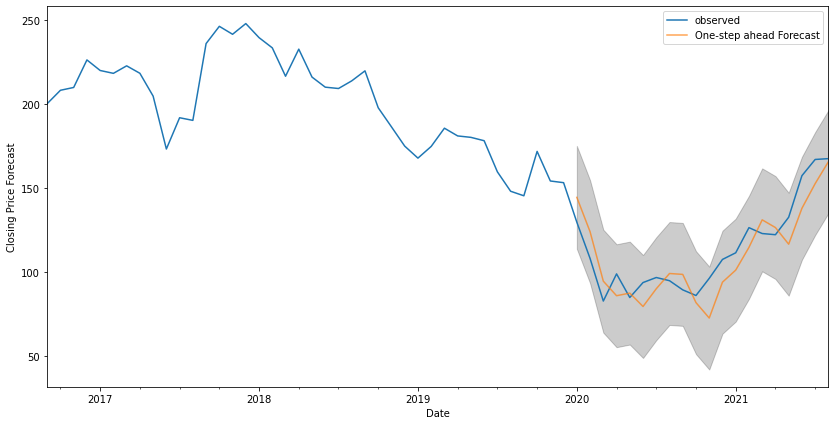

In [14]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = close_price.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price Forecast')
plt.legend()
plt.show()

In [17]:
close_forecasted = pred.predicted_mean
close_truth = close_price['2020-01-01':]
mse = ((close_forecasted - close_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 153.3


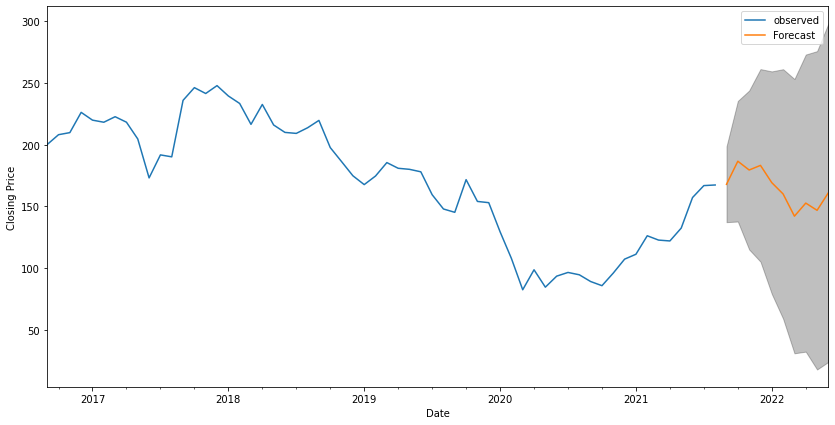

In [18]:
pred_uc = results.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()
ax = close_price.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
plt.legend()
plt.show()